In [86]:
import json
import pyshark
import nest_asyncio
from ast import literal_eval as make_tuple
import statistics
import matplotlib.pyplot as plt
import numpy as np
# nest_asyncio.apply()

In [2]:
def count_quic_packets(filename):
    pcap_data = pyshark.FileCapture(filename)
    count = 0
    packets_count = 0
    for packet in pcap_data:
        packets_count += 1
        # if packet.highest_layer == "QUIC":
        #     count += 1
        for layer in packet:
            if layer.layer_name == 'quic':
                count += 1

    print(f"quic packets count: {count}")
    print(f"packets count: {packets_count}")
    pcap_data.close()

In [3]:
def initial_resumption_statistics(filename):
    pcap_data = pyshark.FileCapture(filename)
    count_initial_packets = 0
    count_resumption_packets = 0  # these are Initial packets that contain a token (token_length != 0)

    for packet in pcap_data:
        # if packet.highest_layer == "QUIC":
        for layer in packet:
            if layer.layer_name == 'quic':
                if int(packet.quic.header_form) == 1 and int(packet.quic.long_packet_type) == 0:
                    count_initial_packets += 1
                    if int(packet.quic.token_length) != 0:
                        count_resumption_packets += 1
                break
    print(f"count Initial packets: {count_initial_packets}")
    print(f"count resumption packets: {count_resumption_packets}")
    print(f"ratio of resumption packets:  {count_resumption_packets / count_initial_packets}")
    pcap_data.close()

In [4]:
# returns the string that represents the ip and port tuple given
def get_tuple_string(ip, port):
    return str(ip) + "-" + str(port)

In [5]:
# returns two options of 4-tuple of the given packet, the two options differ in the source and destination order
def get_four_tuple(packet):

    src_tuple = get_tuple_string(packet.ip.src, packet.udp.srcport)
    dst_tuple = get_tuple_string(packet.ip.dst, packet.udp.dstport)
    return (src_tuple, dst_tuple), (dst_tuple, src_tuple)

In [19]:
# appends an entry to the given dictionary, with the given parameters
def append_to_dict(connections: dict, src_dst_tuple, dst_src_tuple, timestamp, token, initial):
    if (src_dst_tuple, dst_src_tuple) in connections.keys():
        connections[(src_dst_tuple, dst_src_tuple)] += [",".join([timestamp, str(src_dst_tuple), token, initial])]
    elif (dst_src_tuple, src_dst_tuple) in connections.keys():
        connections[(dst_src_tuple, src_dst_tuple)] += [",".join([timestamp, str(src_dst_tuple), token, initial])]
    else:
        connections[(src_dst_tuple, dst_src_tuple)] = [",".join([timestamp, str(src_dst_tuple), token, initial])]

In [17]:
# build a dictionary that contains as keys the IP + Port tuple of both endpoints of a connection.
# the values are timestamp, source IP + Port, destination IP + Port, bool=true if token is available,
def clients_dict(pcap_data, out_file):
    connections = {}
    for packet in pcap_data:
        layers = [layer.layer_name for layer in packet]
        if "quic" in layers and "udp" in layers:
            timestamp = packet.sniff_timestamp
            src_dst_tuple, dst_src_tuple = get_four_tuple(packet)
            initial = "initial" if int(packet.quic.header_form) == 1 and int(packet.quic.long_packet_type) == 0 else "non_initial"
            token = "token_available" if initial == "initial" and int(packet.quic.token_length) != 0 else "no_token_available"
            append_to_dict(connections,
                           src_dst_tuple,
                           dst_src_tuple,
                           timestamp,
                           token,
                           initial)

    with open(out_file, 'w') as f:
        json.dump({str(k): v for k, v in connections.items()}, f, indent=4)

In [8]:
files_base_path = "../pcap-data/DATA/ALLOT/YouTube/"

In [34]:
filename1 = files_base_path + "1667395874.0_video_qoe_1_R9JNA0DNB9J_2022-11-02_15-31-14_00000.pcap"
count_quic_packets(filename1)
initial_resumption_statistics(filename1)

quic packets count: 23240
packets count: 23243
count Initial packets: 123
count resumption packets: 54
ratio of resumption packets:  0.43902439024390244


In [87]:
filename2 = files_base_path + "1667395874.0_video_qoe_2_R9JNA0DNB9J_2022-11-02_15-31-14_00000.pcap"
count_quic_packets(filename2)
initial_resumption_statistics(filename2)

KeyboardInterrupt: 

In [38]:
all_filename = files_base_path + "1660633522.0_video_qoe_all_2022-08-16_10-05-22_00000.pcap"
count_quic_packets(all_filename)
initial_resumption_statistics(all_filename)

quic packets count: 403151
count Initial packets: 894
count resumption packets: 542
ratio of resumption packets:  0.6062639821029083


In [11]:
filename2 = files_base_path + "1667395874.0_video_qoe_2_R9JNA0DNB9J_2022-11-02_15-31-14_00000.pcap"
initial_resumption_statistics(filename2)

count Initial packets: 170
count resumption packets: 76
ratio of resumption packets:  0.4470588235294118


In [31]:
filename3 = files_base_path + "1667395874.0_video_qoe_3_R9JNA0DNB9J_2022-11-02_15-31-14_00000.pcap"
count_quic_packets(filename3)
initial_resumption_statistics(filename3)

quic packets count: 1597
packets count: 2867


KeyboardInterrupt: 

In [70]:
filename3 = files_base_path + "1667395874.0_video_qoe_3_R9JNA0DNB9J_2022-11-02_15-31-14_00000"
suffix = ".pcap"
filename = filename3 + suffix
pcap_data = pyshark.FileCapture(filename)
clients_dict(pcap_data, out_file=filename3 + ".json")

In [16]:
filename3 = files_base_path + "1667395874.0_video_qoe_2_R9JNA0DNB9J_2022-11-02_15-31-14_00000"
suffix = ".pcap"
filename = filename3 + suffix
pcap_data = pyshark.FileCapture(filename)
clients_dict(pcap_data, out_file=filename3 + ".json")

Packet (Length: 1292)
Layer ETH:
	Destination: 00:50:56:ad:9d:df
	Address: 00:50:56:ad:9d:df
	.... ..0. .... .... .... .... = LG bit: Globally unique address (factory default)
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	Source: 9c:a5:13:f0:ae:87
	.... ..0. .... .... .... .... = LG bit: Globally unique address (factory default)
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	Type: IPv4 (0x0800)
	Address: 9c:a5:13:f0:ae:87
Layer IP:
	0100 .... = Version: 4
	.... 0101 = Header Length: 20 bytes (5)
	Differentiated Services Field: 0x00 (DSCP: CS0, ECN: Not-ECT)
	0000 00.. = Differentiated Services Codepoint: Default (0)
	.... ..00 = Explicit Congestion Notification: Not ECN-Capable Transport (0)
	Total Length: 1278
	Identification: 0x8f1b (36635)
	Flags: 0x40, Don't fragment
	0... .... = Reserved bit: Not set
	.1.. .... = Don't fragment: Set
	..0. .... = More fragments: Not set
	Fragment Offset: 0
	Time to Live: 64
	Protocol: UDP (17)
	Heade

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
filename3 = files_base_path + "1660633522.0_video_qoe_all_2022-08-16_10-05-22_00000"
suffix = ".pcap"
filename = filename3 + suffix
pcap_data = pyshark.FileCapture(filename)
clients_dict(pcap_data, out_file=filename3 + ".json")

In [23]:
def read_json_to_dict(filename):
    connections = {}
    with open(filename) as file:
        connections = json.load(file)

    return connections

In [115]:
def connections_number_starting_with_token(connections):
    count_with_token = 0
    for v in connections.values():
        if v[0].split(",")[3] == 'token_available':
            count_with_token += 1
    return count_with_token

In [117]:
connections = read_json_to_dict(filename3 + ".json")
packets_number_per_connection = sorted([len(v) for v in connections.values()])

number of connections: 320
number of connections using tokens in the first Initial packet of the connection: 306
ratio of connections using tokens and overall connections: 0.95625
number of packets per connection median: 28.0
number of packets per connection mean: 1256.984375
number of packets overall: 402235
sniffing time: 6578.2 seconds, 109.63666666666667 minutes
number of packets per connection: [15, 16, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 

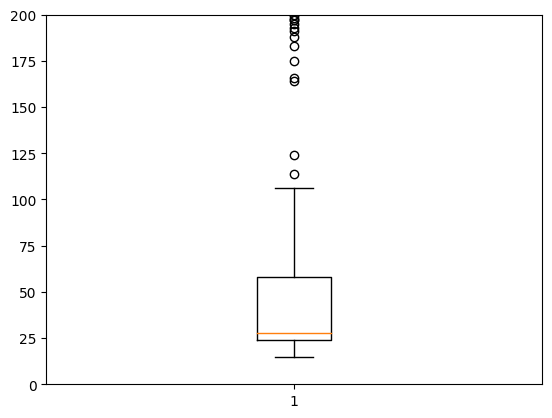

In [123]:
print(f"number of connections: {len(connections.keys())}")
print(f"number of connections using tokens in the first Initial packet of the connection: {connections_number_starting_with_token(connections)}")
print(f"ratio of connections using tokens and overall connections: {connections_number_starting_with_token(connections) / len(connections.keys())}")
print(f"number of packets per connection median: {statistics.median(packets_number_per_connection)}")
print(f"number of packets per connection mean: {statistics.mean(packets_number_per_connection)}")
print(f"number of packets overall: {sum(packets_number_per_connection)}")
print(f"sniffing time: {6578.2} seconds, {6578.2 / 60} minutes")
print(f"number of packets per connection: {packets_number_per_connection}")
plt.boxplot(packets_number_per_connection)
plt.ylim(0,200)
plt.show()

In [73]:
four_tuples = []
for k in connections.keys():
    four_tuples += [make_tuple(k)[0][0], make_tuple(k)[0][1], make_tuple(k)[1][0], make_tuple(k)[1][1]]

print(len(four_tuples))
four_tuples = sorted(list(set(four_tuples)))
print(len(four_tuples))
for t in four_tuples:
    print(t)
# print(len(set(four_tuples)))
# print(set(four_tuples))
# print(('192.168.3.135-59561', '173.194.76.100-443') in four_tuples)

1280
386
142.250.178.150-443
142.250.179.110-443
142.250.181.234-443
142.250.181.246-443
142.250.184.206-443
142.250.184.225-443
142.250.184.228-443
142.250.184.238-443
142.250.185.106-443
142.250.185.138-443
142.250.185.150-443
142.250.185.174-443
142.250.185.214-443
142.250.185.234-443
142.250.185.238-443
142.250.185.66-443
142.250.185.74-443
142.250.185.86-443
142.250.185.99-443
142.250.186.106-443
142.250.186.110-443
142.250.186.138-443
142.250.186.170-443
142.250.186.182-443
142.250.186.42-443
142.250.186.74-443
142.250.186.78-443
142.250.201.182-443
142.250.74.202-443
142.250.74.238-443
142.251.39.106-443
142.251.5.100-443
142.251.5.102-443
142.251.5.139-443
172.217.16.142-443
172.217.16.202-443
172.217.16.206-443
172.217.18.10-443
172.217.18.106-443
172.217.18.2-443
172.217.18.214-443
172.217.18.22-443
172.217.23.110-443
173.194.76.100-443
173.194.76.101-443
173.194.76.102-443
173.194.76.113-443
173.194.76.138-443
173.194.76.139-443
192.168.3.135-32968
192.168.3.135-33027
192.16

{(1, 2), (2, 1)}
